In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [4]:
def OneHotDecoder(Y_oh):
    return np.array([np.argmax(el) for el in Y_oh])

In [5]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [6]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [7]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

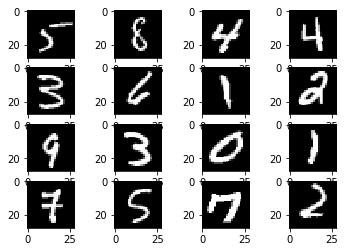

In [8]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [9]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / (std + 0.0001)
X_test = (X_test - mean) / (std + 0.0001)

In [10]:
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.001):
        dz[self.x < 0] = 0
        return dz

In [11]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        x = np.exp(x)
        return x / np.sum(x) 
    def backward(self, dz, lr=0.0005):
        sigma = self.forward(self.x) 
        return np.dot(dz, sigma * (np.eye(sigma.shape[0], sigma.shape[0]) - sigma).T)

In [12]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return - np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.0005):
        return - self.y_true / self.y_hat

In [13]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.0005):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [14]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [15]:
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        #self.o = Dropout(0.4)
        self.d = Dense(784, 200, rlambda)
        self.d1 = Dense(200, 20, rlambda)
        self.d2 = Dense(20, 10, rlambda)        
        self.m = ReLU()
        self.m1 = ReLU()
        self.m2 = ReLU()
        self.s = Softmax()
    
    def forward(self, x):
        #net = self.o.forward(x)
        net = self.d.forward(x)
        net = self.m.forward(net)
        net = self.d1.forward(net)
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        dz = self.m.backward(dz, lr)
        dz = self.d.backward(dz, lr)
        #dz = self.o.backward(dz, lr)
        return dz

In [16]:
np.random.seed(17)
net = MnistNet(rlambda = 0.001)
loss = CrossEntropy()
epochs = 100
L_train = []
L_test = []
Acc_train = []
Acc_test = []
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train_oh, test_size=0.15,random_state=1, stratify = Y_train_oh)
for iter in tqdm.tqdm_notebook(range(epochs)):
    L_acc = 0.
    sh = list(range(x_train.shape[0]))
    np.random.shuffle(sh)
    for i in range(x_train.shape[0]):
        x = x_train[sh[i]]
        y = y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) + net.d.get_reg_loss() + net.d1.get_reg_loss() #+ net.d2.get_reg_loss()
        L_acc += L 
        lr = 1 / (i ** 0.7 + 500)
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= y_train.shape[0]
    Acc_train.append(compute_acc(x_train, OneHotDecoder(y_train), net))
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(x_test.shape[0]):
        x = x_test[i]
        y = y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) + net.d.get_reg_loss() + net.d1.get_reg_loss() #+ net.d2.get_reg_loss()
        L_e_acc += L
    L_e_acc /= y_test.shape[0]
    L_test.append(L_e_acc)
    Acc_test.append(compute_acc(x_test, OneHotDecoder(y_test), net))
    #print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))

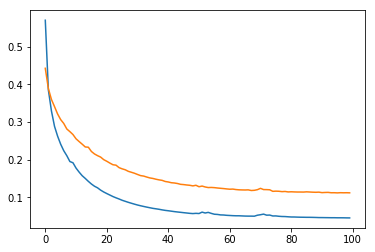

In [17]:
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

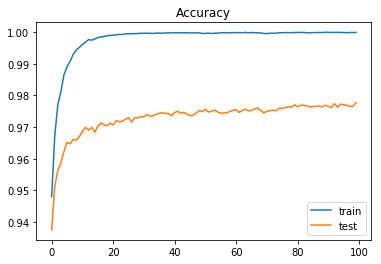

In [18]:
plt.title('Accuracy')
plt.plot(Acc_train, label="train")
plt.plot(Acc_test, label="test")
plt.legend()

In [ ]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test, net)